In [54]:
from transformers import ViTFeatureExtractor
import requests
from PIL import Image

In [51]:
feature_extractor = ViTFeatureExtractor.from_pretrained("facebook/vit-mae-large")

In [52]:
feature_extractor

ViTFeatureExtractor {
  "do_normalize": true,
  "do_resize": true,
  "feature_extractor_type": "ViTFeatureExtractor",
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "resample": 2,
  "size": 224
}

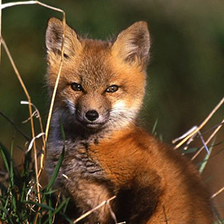

In [55]:
url = "https://user-images.githubusercontent.com/11435359/147738734-196fd92f-9260-48d5-ba7e-bf103d29364d.jpg"
image = Image.open(requests.get(url, stream=True).raw)
image

In [56]:
pixel_values = feature_extractor(image, return_tensors="pt").pixel_values     

In [57]:
pixel_values.shape

torch.Size([1, 3, 224, 224])

In [58]:
import torch
import numpy as np
import matplotlib.pyplot as plt

imagenet_mean = np.array(feature_extractor.image_mean)
imagenet_std = np.array(feature_extractor.image_std)

def show_image(image, title=''):
    # image is [H, W, 3]
    assert image.shape[2] == 3
    plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())
    plt.title(title, fontsize=16)
    plt.axis('off')
    return

def visualize(pixel_values, model):
    # forward pass
    outputs = model(pixel_values)
    y = model.unpatchify(outputs.logits)
    y = torch.einsum('nchw->nhwc', y).detach().cpu()
    
    # visualize the mask
    mask = outputs.mask.detach()
    mask = mask.unsqueeze(-1).repeat(1, 1, model.config.patch_size**2 *3)  # (N, H*W, p*p*3)
    mask = model.unpatchify(mask)  # 1 is removing, 0 is keeping
    mask = torch.einsum('nchw->nhwc', mask).detach().cpu()
    
    x = torch.einsum('nchw->nhwc', pixel_values)

    # masked image
    im_masked = x * (1 - mask)

    # MAE reconstruction pasted with visible patches
    im_paste = x * (1 - mask) + y * mask

    # make the plt figure larger
    plt.rcParams['figure.figsize'] = [24, 24]

    plt.subplot(1, 4, 1)
    show_image(x[0], "original")

    plt.subplot(1, 4, 2)
    show_image(im_masked[0], "masked")

    plt.subplot(1, 4, 3)
    show_image(y[0], "reconstruction")

    plt.subplot(1, 4, 4)
    show_image(im_paste[0], "reconstruction + visible")

    plt.show()

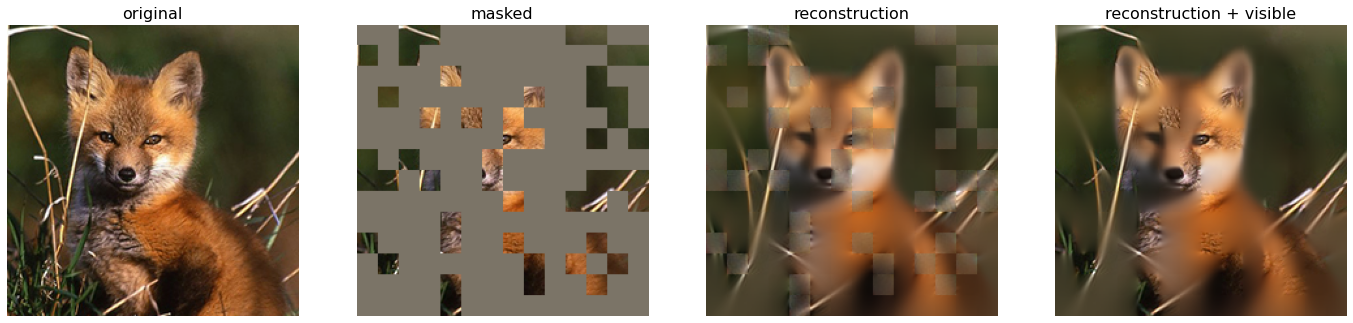

In [59]:
from transformers import ViTMAEForPreTraining

# make random mask reproducible (comment out to make it change)
torch.manual_seed(2)

model = ViTMAEForPreTraining.from_pretrained("facebook/vit-mae-large")

visualize(pixel_values, model)

In [64]:
image_2 = Image.open('/mnt/workspace/padchest/images-small/100014625199913409730274754282179594842_0jycky.png')
image_2 = image_2.point(lambda x: x * (255 / 65535)).convert('RGB')
pixel_values_2 = feature_extractor(image_2, return_tensors="pt").pixel_values

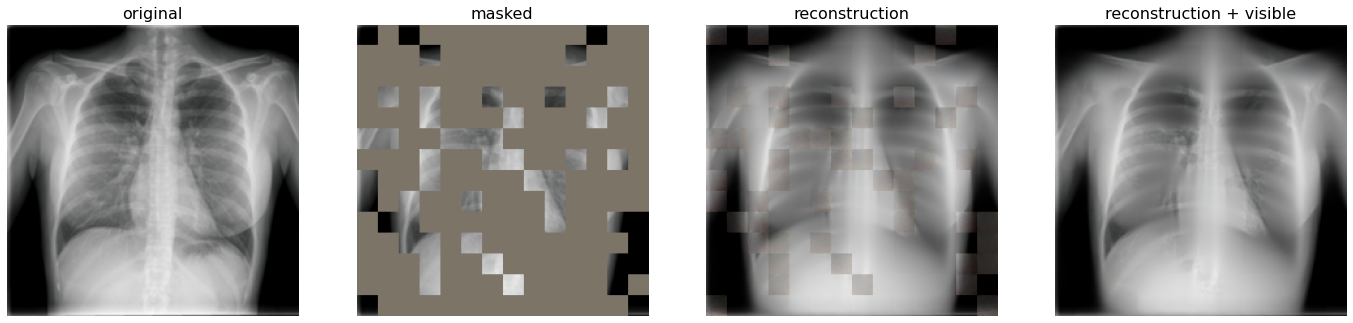

In [65]:
visualize(pixel_values_2, model)

In [21]:
from transformers import ViTMAEForPreTraining

In [66]:
model = ViTMAEForPreTraining.from_pretrained('facebook/vit-mae-large')

In [67]:
outputs = model(pixel_values_2)

In [70]:
outputs.keys()

odict_keys(['loss', 'logits', 'mask', 'ids_restore'])

In [69]:
outputs.logits.shape

torch.Size([1, 196, 768])

In [71]:
from transformers import ViTModel

In [72]:
model = ViTModel.from_pretrained("facebook/vit-mae-large")

You are using a model of type vit_mae to instantiate a model of type vit. This is not supported for all configurations of models and can yield errors.
Some weights of the model checkpoint at facebook/vit-mae-large were not used when initializing ViTModel: ['decoder.decoder_layers.0.attention.output.dense.weight', 'decoder.decoder_layers.7.attention.attention.value.weight', 'decoder.decoder_layers.1.layernorm_before.bias', 'decoder.decoder_layers.0.attention.attention.value.weight', 'decoder.decoder_layers.1.attention.attention.key.weight', 'decoder.decoder_layers.4.attention.attention.value.bias', 'decoder.decoder_layers.2.layernorm_before.weight', 'decoder.decoder_layers.4.layernorm_before.weight', 'decoder.decoder_layers.6.layernorm_before.weight', 'decoder.decoder_layers.7.layernorm_before.bias', 'decoder.decoder_layers.0.intermediate.dense.weight', 'decoder.decoder_layers.0.intermediate.dense.bias', 'decoder.decoder_layers.3.attention.attention.key.weight', 'decoder.decoder_layers.

In [73]:
img = Image.open('/mnt/workspace/padchest/images-small/100014625199913409730274754282179594842_0jycky.png')
img = img.point(lambda x: x * (255 / 65535)).convert('RGB')
pv = feature_extractor(img, return_tensors="pt").pixel_values

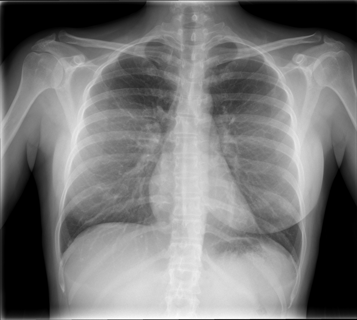

In [74]:
img

In [75]:
output = model(pv)

In [76]:
output.keys()

odict_keys(['last_hidden_state', 'pooler_output'])

In [79]:
output.pooler_output.shape

torch.Size([1, 1024])

In [40]:
import re

In [41]:
tmp = re.compile(r'\bpooler\b')

In [47]:
tmp.search(' .pooler.s ')

<_sre.SRE_Match object; span=(2, 8), match='pooler'>

In [48]:
for name, param in model.named_parameters():
    if tmp.search(name):
        print(name)

pooler.dense.weight
pooler.dense.bias
